[*********************100%***********************]  1 of 1 completed


🔍 Mean Squared Error Comparison:

Linear Regression: MSE = 4925619.08
Decision Tree: MSE = 13409862.06
Random Forest: MSE = 7990730.19
Support Vector Machine: MSE = 343526585.42
K-Nearest Neighbors: MSE = 7792603.09

📈 Predicted Bitcoin Price for Day 1: $118074.42
📈 Predicted Bitcoin Price for Day 2: $118811.05


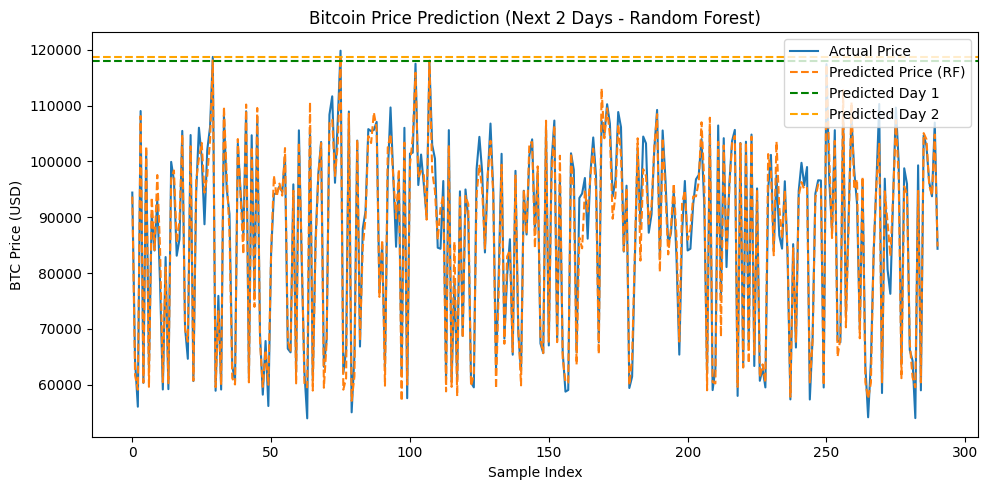

In [10]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# STEP 1: Fetch BTC Price Data
# ------------------------------------------------------------
end_date = datetime.today()
start_date = end_date - timedelta(days=365)
btc_df = yf.download('BTC-USD', start=start_date, end=end_date, interval='1d', auto_adjust=False)

btc_df = btc_df[['Close']].rename(columns={'Close': 'price'})
btc_df['price'] = btc_df['price'].ffill()
btc_df.reset_index(inplace=True)

# ------------------------------------------------------------
# STEP 2: Feature Engineering
# ------------------------------------------------------------
btc_df['price_t-1'] = btc_df['price'].shift(1)
btc_df['price_t-2'] = btc_df['price'].shift(2)
btc_df['price_t-3'] = btc_df['price'].shift(3)
btc_df.dropna(inplace=True)

X = btc_df[['price_t-1', 'price_t-2', 'price_t-3']]
y = btc_df['price'].values.ravel()

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# ------------------------------------------------------------
# STEP 3: Train-Test Split
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.80, random_state=42)

# ------------------------------------------------------------
# STEP 4: Train and Compare ML Models
# ------------------------------------------------------------
algorithms = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Support Vector Machine': SVR(),
    'K-Nearest Neighbors': KNeighborsRegressor()
}

print("🔍 Mean Squared Error Comparison:\n")
for name, model in algorithms.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name}: MSE = {mse:.2f}")

# ------------------------------------------------------------
# STEP 5: Predict the Next 2 Days Using Best Model (Random Forest)
# ------------------------------------------------------------
best_model = algorithms['Random Forest']
latest_features = btc_df[['price_t-1', 'price_t-2', 'price_t-3']].iloc[-1:].values
latest_scaled = scaler.transform(latest_features)

# Day 1 Prediction
day1_price = best_model.predict(latest_scaled)[0]

# Prepare features for Day 2 (use day1_price as price_t-1)
new_features = np.array([[day1_price, latest_features[0][0], latest_features[0][1]]])
new_scaled = scaler.transform(new_features)
day2_price = best_model.predict(new_scaled)[0]

print(f"\n📈 Predicted Bitcoin Price for Day 1: ${day1_price:.2f}")
print(f"📈 Predicted Bitcoin Price for Day 2: ${day2_price:.2f}")

# ------------------------------------------------------------
# STEP 6: Visualization
# ------------------------------------------------------------
rf_pred = best_model.predict(X_test)
plt.figure(figsize=(10,5))
plt.plot(y_test, label='Actual Price')
plt.plot(rf_pred, label='Predicted Price (RF)', linestyle='--')
plt.axhline(day1_price, color='green', linestyle='--', label='Predicted Day 1')
plt.axhline(day2_price, color='orange', linestyle='--', label='Predicted Day 2')
plt.title("Bitcoin Price Prediction (Next 2 Days - Random Forest)")
plt.xlabel("Sample Index")
plt.ylabel("BTC Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()
